# Business Growth Radar Chart

## Import Data Source

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from functools import reduce
import datetime

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [2]:
as_week = 2023024
data_src = f"../../data/raw/Raw-Agg Perf_Wk {as_week}.csv"
df_bg = pd.read_csv(data_src)

cols = ['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'PPN_TM']
df_bg = df_bg[cols]
df_bg.head(3)

,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,METRIC_CD,METRIC_NAME,AGG_TYPE,ACTUAL_SNAP,ACTUAL_AGG,TARGET_SNAP,TARGET_AGG,PPN_TM
0,20230301,2023009,202303,20231,2023,B2R000100,Postpaid Revenue,S,1.376380e+07,1.376380e+07,6.416632e+06,6.416632e+06,2023-06-22 08:49:59
1,20230302,2023009,202303,20231,2023,B2R000100,Postpaid Revenue,S,8.521882e+08,8.659520e+08,8.645637e+08,8.709803e+08,2023-06-22 08:49:59
2,20230303,2023009,202303,20231,2023,B2R000100,Postpaid Revenue,S,9.943611e+07,9.653881e+08,9.872504e+07,9.697053e+08,2023-06-22 08:49:59


In [3]:
df_bg.shape

(565, 13)

In [4]:
df_bg['METRIC_NAME'].unique()

array(['Postpaid Revenue', 'Prepaid Revenue',
       'TDG Revenue (Performance View)', 'TOL Revenue', 'TVS Revenue'],
      dtype=object)

## Data Preporation

In [5]:
''' Dict '''

weight_dict = {'Prepaid Revenue': 0.28, 
              'Postpaid Revenue': 0.45, 
              'TOL Revenue': 0.12, 
              'TVS Revenue': 0.04, 
              'TDG Revenue (Performance View)': 0.02}

score_dict = {1: 0.8, 
              2: 0.9, 
              3: 1, 
              4: 1.1, 
              5: 1.2}

In [6]:
''' Functions '''


def unit_mb(baht):
    n = baht

    unit_mb = n / 1000000
    
    return unit_mb


def weight_score(achv):
    n = achv
    score = 0

    if n < score_dict[1]: score = 1 
    elif n < score_dict[2]: score = (n-score_dict[1]) / (score_dict[2]-score_dict[1]) + 1
    elif n < score_dict[3]: score = (n-score_dict[2]) / (score_dict[3]-score_dict[2]) + 2
    elif n < score_dict[4]: score = (n-score_dict[3]) / (score_dict[4]-score_dict[3]) + 3
    elif n < score_dict[5]: score = (n-score_dict[4]) / (score_dict[5]-score_dict[4]) + 4
    elif n >= score_dict[5]: score = 5
    else: score = 0

    return score

In [7]:
''' Rawdata '''

''' Filters '''
# df_bg = df_bg[df_bg['TM_KEY_MTH'] <= 202306] # MONTH filter
# df_bg = df_bg[df_bg['TM_KEY_WK'] <= 2023024] # WEEK filter
# df_bg = df_bg[df_bg['TM_KEY_DAY'] <= 20230620] # DAY filter

''' Modify '''
df_bg = df_bg.rename(columns={'ACTUAL_SNAP':'ACT_SNAP', 'ACTUAL_AGG':'ACT_AGG', 'TARGET_SNAP':'TGT_SNAP', 'TARGET_AGG':'TGT_AGG'})

''' Add new column '''
df_bg['MTH_DESC'] = pd.to_datetime(df_bg['TM_KEY_MTH'], format='%Y%m', errors='coerce').dt.strftime('%B')
df_bg['WK_LABEL'] = df_bg['TM_KEY_WK'].apply(str).str[5:].astype(int)
df_bg['DAY_LABEL'] = df_bg['TM_KEY_DAY'].apply(str).str[6:].astype(int)

In [8]:
''' Create Dataframe '''

''' Aggregate type : S '''
df_agg_s = df_bg[df_bg['AGG_TYPE']=='S']

''' Aggregate type : N '''
df_agg_n = df_bg[df_bg['AGG_TYPE']=='N'].dropna(subset='ACT_SNAP')

In [9]:
''' Period Values '''

curr_yr = df_bg['TM_KEY_YR'].max()
last_yr = df_bg['TM_KEY_YR'].max() - 1
curr_mth = df_bg['TM_KEY_MTH'].max()
curr_mth_desc = pd.to_datetime(curr_mth, format='%Y%m', errors='coerce').strftime('%B')
last_mth = int(f'{str(last_yr)}12') if str(curr_mth)[4:]=='01' else curr_mth-1
curr_wk = df_bg['TM_KEY_WK'].max()
last_wk = df_bg['TM_KEY_WK'].drop_duplicates().shift().max()
curr_wk_label = df_bg['WK_LABEL'].iloc[-1]
curr_day = df_bg['TM_KEY_DAY'].max()
last_day = df_bg['TM_KEY_DAY'].drop_duplicates().shift().max()
curr_day_label = df_bg['DAY_LABEL'].iloc[-1]
last_ppn_tm = df_bg['PPN_TM'].max()

wk_day_start = int(str(df_bg[df_bg['TM_KEY_WK']==curr_wk]['TM_KEY_DAY'].min())[6:])
wk_day_end = int(str(df_bg[df_bg['TM_KEY_WK']==curr_wk]['TM_KEY_DAY'].max())[6:])

## ** Yearly **

### YR : Aggregation

In [10]:
''' Create Dataframe '''

df_agg_s_yr = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'AGG_TYPE']).agg({'ACT_SNAP': 'sum', 'TGT_SNAP': 'sum'}).reset_index()
df_agg_n_yr = df_agg_n.loc[df_agg_n.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'AGG_TYPE', 'ACT_SNAP', 'TGT_SNAP']]
df_rev_yr = pd.concat([df_agg_s_yr, df_agg_n_yr])

''' YTD '''
df_rev_yr = df_rev_yr[df_rev_yr['TM_KEY_YR']==curr_yr]

''' Aggregation '''
df_rev_yr['BASELINE'] = df_rev_yr.groupby('METRIC_CD')['ACT_SNAP'].shift().fillna(0)
df_rev_yr['%ACHV'] = (df_rev_yr['ACT_SNAP']-df_rev_yr['BASELINE']) / (df_rev_yr['TGT_SNAP']-df_rev_yr['BASELINE'])
df_rev_yr['%ACHV'] = np.where(df_rev_yr['%ACHV'] < 1.2, df_rev_yr['%ACHV'], 1.2)
df_rev_yr['WEIGHT'] = df_rev_yr['METRIC_NAME'].map(weight_dict)
df_rev_yr['WEIGHT_ACT'] = df_rev_yr['%ACHV'] * df_rev_yr['WEIGHT']

df_rev_yr

,METRIC_CD,METRIC_NAME,TM_KEY_YR,AGG_TYPE,ACT_SNAP,TGT_SNAP,BASELINE,%ACHV,WEIGHT,WEIGHT_ACT
0,B1R000100,Prepaid Revenue,2023,S,1.329163e+10,1.334196e+10,0.0,0.996228,0.28,0.278944
1,B2R000100,Postpaid Revenue,2023,S,2.405308e+10,2.434912e+10,0.0,0.987842,0.45,0.444529
2,TB3R000100,TOL Revenue,2023,S,5.057140e+09,5.559712e+09,0.0,0.909605,0.12,0.109153
3,TB4R000100,TVS Revenue,2023,S,1.090575e+09,1.432222e+09,0.0,0.761457,0.04,0.030458
336,TNSC00142,TDG Revenue (Performance View),2023,N,5.180000e+08,4.600000e+08,0.0,1.126087,0.02,0.022522


In [11]:
''' YTD Values '''

ytd_bg_achv = df_rev_yr['WEIGHT_ACT'].sum() / df_rev_yr['WEIGHT'].sum()
ytd_bg_act = df_rev_yr['ACT_SNAP'].sum()
ytd_bg_tgt = df_rev_yr['TGT_SNAP'].sum()
ytd_bg_score = weight_score(ytd_bg_achv)

ytd_bg_score

2.731926320275357

### YR : Visualizations

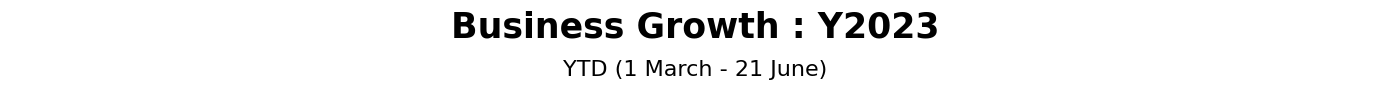

In [12]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"Business Growth : Y{curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"YTD (1 March - {curr_day_label} {curr_mth_desc})", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

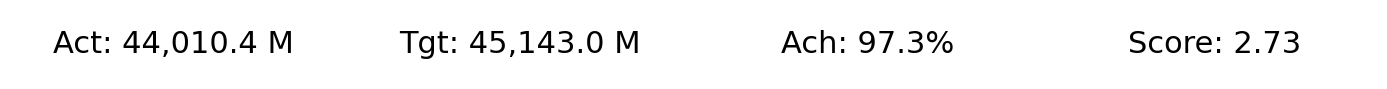

In [13]:
''' YTD Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(unit_mb(ytd_bg_act),',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(ytd_bg_tgt),',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(ytd_bg_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"Score: {format(ytd_bg_score,',.2f')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

## ** Monthly **

### MTH : Aggregation

In [14]:
''' Create Dataframe '''

df_agg_s_mth = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'AGG_TYPE']).agg({'ACT_SNAP': 'sum', 'TGT_SNAP': 'sum'}).reset_index()
df_agg_n_mth = df_agg_n.loc[df_agg_n.groupby('TM_KEY_MTH')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'AGG_TYPE', 'ACT_SNAP', 'TGT_SNAP']]
df_rev_mth = pd.concat([df_agg_s_mth, df_agg_n_mth])

''' MTD '''
df_rev_mth = df_rev_mth[df_rev_mth['TM_KEY_MTH']==curr_mth]

''' Aggregation '''
df_rev_mth['BASELINE'] = df_rev_mth.groupby('METRIC_CD')['ACT_SNAP'].shift().fillna(0)
df_rev_mth['%ACHV'] = (df_rev_mth['ACT_SNAP']-df_rev_mth['BASELINE']) / (df_rev_mth['TGT_SNAP']-df_rev_mth['BASELINE'])
df_rev_mth['%ACHV'] = np.where(df_rev_mth['%ACHV'] < 1.2, df_rev_mth['%ACHV'], 1.2)
df_rev_mth['WEIGHT'] = df_rev_mth['METRIC_NAME'].map(weight_dict)
df_rev_mth['WEIGHT_ACT'] = df_rev_mth['%ACHV'] * df_rev_mth['WEIGHT']

df_rev_mth

,METRIC_CD,METRIC_NAME,TM_KEY_MTH,MTH_DESC,AGG_TYPE,ACT_SNAP,TGT_SNAP,BASELINE,%ACHV,WEIGHT,WEIGHT_ACT
3,B1R000100,Prepaid Revenue,202306,June,S,2.289664e+09,2.319163e+09,0.0,0.987280,0.28,0.276438
7,B2R000100,Postpaid Revenue,202306,June,S,4.213153e+09,4.385945e+09,0.0,0.960603,0.45,0.432271
11,TB3R000100,TOL Revenue,202306,June,S,9.779204e+08,1.039215e+09,0.0,0.941018,0.12,0.112922
15,TB4R000100,TVS Revenue,202306,June,S,1.685308e+08,1.913725e+08,0.0,0.880643,0.04,0.035226
336,TNSC00142,TDG Revenue (Performance View),202306,June,N,5.180000e+08,4.600000e+08,0.0,1.126087,0.02,0.022522


In [15]:
''' MTD Values '''

mtd_bg_achv = df_rev_mth['WEIGHT_ACT'].sum() / df_rev_mth['WEIGHT'].sum()
mtd_bg_act = df_rev_mth['ACT_SNAP'].sum()
mtd_bg_tgt = df_rev_mth['TGT_SNAP'].sum()
mtd_bg_score = weight_score(mtd_bg_achv)

mtd_bg_score

2.663511529324894

### MTH : Visualizations

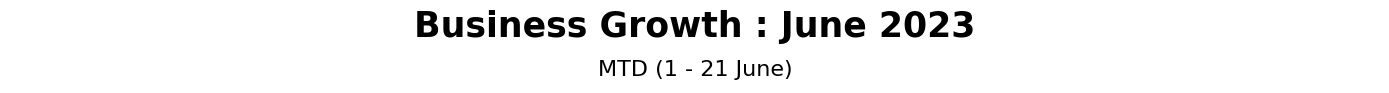

In [16]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"Business Growth : {curr_mth_desc} {curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"MTD (1 - {curr_day_label} {curr_mth_desc})", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

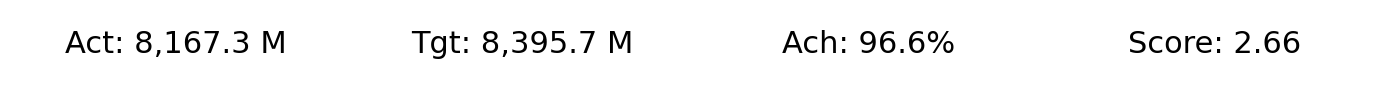

In [17]:
''' MTD Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(unit_mb(mtd_bg_act),',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(mtd_bg_tgt),',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(mtd_bg_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"Score: {format(mtd_bg_score,',.2f')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

## ** Weekly **

### WK : Aggregation

In [18]:
''' Create Dataframe '''

df_agg_s_wk = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'AGG_TYPE']).agg({'ACT_SNAP': 'sum', 'TGT_SNAP': 'sum', 'DAY_LABEL': 'min'}).reset_index()
df_agg_n_wk = df_agg_n.loc[df_agg_n.groupby('TM_KEY_WK')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'AGG_TYPE', 'ACT_SNAP', 'TGT_SNAP']]
df_rev_wk = pd.concat([df_agg_s_wk, df_agg_n_wk])

''' WTD '''
df_rev_wk = df_rev_wk[df_rev_wk['TM_KEY_WK']==curr_wk]

''' Aggregation '''
df_rev_wk['BASELINE'] = df_rev_wk.groupby('METRIC_CD')['ACT_SNAP'].shift().fillna(0)
df_rev_wk['%ACHV'] = (df_rev_wk['ACT_SNAP']-df_rev_wk['BASELINE']) / (df_rev_wk['TGT_SNAP']-df_rev_wk['BASELINE'])
df_rev_wk['%ACHV'] = np.where(df_rev_wk['%ACHV'] < 1.2, df_rev_wk['%ACHV'], 1.2)
df_rev_wk['WEIGHT'] = df_rev_wk['METRIC_NAME'].map(weight_dict)
df_rev_wk['WEIGHT_ACT'] = df_rev_wk['%ACHV'] * df_rev_wk['WEIGHT']

df_rev_wk

,METRIC_CD,METRIC_NAME,TM_KEY_WK,WK_LABEL,AGG_TYPE,ACT_SNAP,TGT_SNAP,DAY_LABEL,BASELINE,%ACHV,WEIGHT,WEIGHT_ACT
16,B1R000100,Prepaid Revenue,2023025,25,S,1.166162e+08,1.189196e+08,19.0,0.0,0.980631,0.28,0.274577
33,B2R000100,Postpaid Revenue,2023025,25,S,4.364674e+08,4.651401e+08,19.0,0.0,0.938357,0.45,0.422261
50,TB3R000100,TOL Revenue,2023025,25,S,1.477397e+08,1.602484e+08,19.0,0.0,0.921942,0.12,0.110633
67,TB4R000100,TVS Revenue,2023025,25,S,2.481360e+07,2.811601e+07,19.0,0.0,0.882543,0.04,0.035302
336,TNSC00142,TDG Revenue (Performance View),2023025,25,N,5.180000e+08,4.600000e+08,NaN,0.0,1.126087,0.02,0.022522


In [19]:
''' WTD Values '''

wtd_bg_achv = df_rev_wk['WEIGHT_ACT'].sum() / df_rev_wk['WEIGHT'].sum()
wtd_bg_act = df_rev_wk['ACT_SNAP'].sum()
wtd_bg_tgt = df_rev_wk['TGT_SNAP'].sum()
wtd_bg_score = weight_score(wtd_bg_achv)

wtd_bg_score

2.5087209228859138

### WK : Visualizations

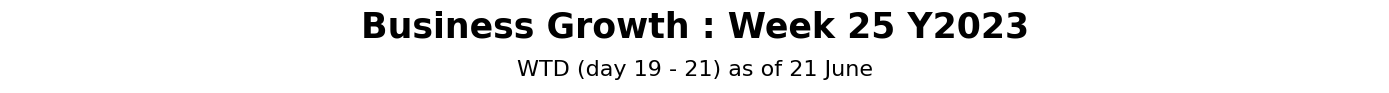

In [20]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"Business Growth : Week {curr_wk_label} Y{curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"WTD (day {wk_day_start} - {wk_day_end}) as of {curr_day_label} {curr_mth_desc}", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

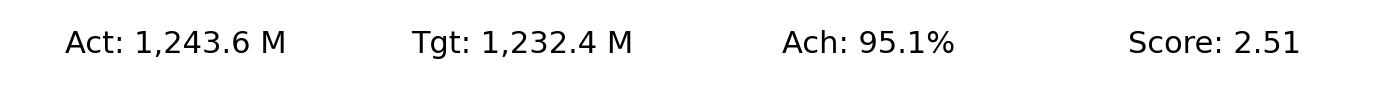

In [21]:
''' WTD Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(unit_mb(wtd_bg_act),',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(wtd_bg_tgt),',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(wtd_bg_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"Score: {format(wtd_bg_score,',.2f')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()